### Overview of repurposed compounds based on patent documents

#### Import modules

In [1]:
import json
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 400
sns.set(style='dark')

### Loading data files

In [4]:
DATA_DIR = '../data/patent_dumps'
FIG_DIR = '../data/figures'
MAPPER_DIR = '../data/mapper'

In [5]:
rare_disease_data = pd.read_csv(f'{DATA_DIR}/orphanet_gene_enumerated_patent_data.tsv', sep='\t')
rare_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person,genes
0,CHEMBL3137316,SCHEMBL1707427,US-20140316139-A1,2014-10-23,C07D 213/89,PFIZER,Pfizer,NaN,NaN,"IL6, NR3C1"
1,CHEMBL3137316,SCHEMBL1707427,US-20140142316-A1,2014-05-22,C07D 213/89,PFIZER,Pfizer,NaN,NaN,"IL6, NR3C1"


In [6]:
alzheimer_disease_data = pd.read_csv(f'{DATA_DIR}/ad_gene_enumerated_patent_data.tsv', sep='\t')
alzheimer_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person,genes
0,CHEMBL1460470,SCHEMBL14919618,US-20140256767-A1,2014-09-11,C07D 401/14,UNIV RUTGERS,Rutgers University,NaN,NaN,"DUSP3, PTPN7, POLB"
1,CHEMBL1460470,SCHEMBL14919618,US-20180148408-A1,2018-05-31,C07D 209/48,UNIV RUTGERS,Rutgers University,NaN,NaN,"DUSP3, PTPN7, POLB"


Drop patents with no assignee names

In [7]:
rare_disease_data.shape, alzheimer_disease_data.shape

((17506, 10), (76321, 10))

In [8]:
rare_disease_data = rare_disease_data[~rare_disease_data['assignee'].isna()]
rare_disease_data.shape

(17375, 10)

In [9]:
alzheimer_disease_data = alzheimer_disease_data[~alzheimer_disease_data['assignee'].isna()]
alzheimer_disease_data.shape

(75616, 10)

### Compound patent distribution

In [10]:
rare_disease_mapper = json.load(open(f'{MAPPER_DIR}/orphanet_chem_smile_mapper.json'))
len(rare_disease_mapper)

585

In [11]:
alzheimer_disease_mapper = json.load(open(f'{MAPPER_DIR}/ad_chem_smile_mapper.json'))
len(alzheimer_disease_mapper)

22962

In [12]:
def compound_patent_dist(df: pd.DataFrame, mapping_dict: dict):
    """Get compounds and the patents they are mentioned in."""
    
    comp_dict = defaultdict(set)
    
    for chembl, patent_idx in tqdm(df[['chembl', 'patent_id']].values):
        status = patent_idx.split('-')[-1]
        
        # Trimming status to be A/B only
        status_index = status[0]
        
        if status_index == 'A':  # non-granted patents
            continue
        
        comp_dict[chembl].add(patent_idx)
        
    comp_count_data = [
        {
            'chembl': comp,
            'total_patent_count': len(patents),
            'smiles': mapping_dict[comp]
        }
        for comp, patents in comp_dict.items()
        if len(patents) > 2
    ]
    
    return pd.DataFrame(comp_count_data), comp_dict

In [13]:
rare_disease_compounds, rare_disease_compound_detailed = compound_patent_dist(
    rare_disease_data, rare_disease_mapper
)

rare_disease_compounds.sort_values(
    by='total_patent_count', inplace=True, ascending=False
)

print(rare_disease_compounds.shape)

rare_disease_compounds = rare_disease_compounds.head(10)

rare_disease_compounds.head(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 491621.68it/s]

(145, 3)


,chembl,total_patent_count,smiles
15,CHEMBL372231,16,COc1cc2c(cc1OS(N)(=O)=O)CC[C@@H]1[C@@H]2CC[C@]...


In [14]:
alzheimers_disease_compounds, alzheimers_disease_compound_detailed = compound_patent_dist(
    alzheimer_disease_data, alzheimer_disease_mapper
)

print(alzheimers_disease_compounds.shape)

alzheimers_disease_compounds = alzheimers_disease_compounds.head(10)

alzheimers_disease_compounds.sort_values(
     by='total_patent_count', inplace=True, ascending=False
)
alzheimers_disease_compounds.head(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 319356.22it/s]

(1928, 3)


,chembl,total_patent_count,smiles
0,CHEMBL414883,10,C[C@@H]1C[C@H]2O[C@@H]2/C=C\C=C\C(=O)Cc2c(Cl)c...


### Check overlap with approved or clinical trial compounds

In [15]:
rare_disease_phase_compounds = pd.read_csv('rare_disease_phase_info.tsv', sep='\t')
alzheimer_disease_phase_compounds = pd.read_csv('ad_phase_info.tsv', sep='\t')
rare_disease_phase_compounds.shape, alzheimer_disease_phase_compounds.shape

((3, 3), (5, 3))

### Visualisation - Rare diseases

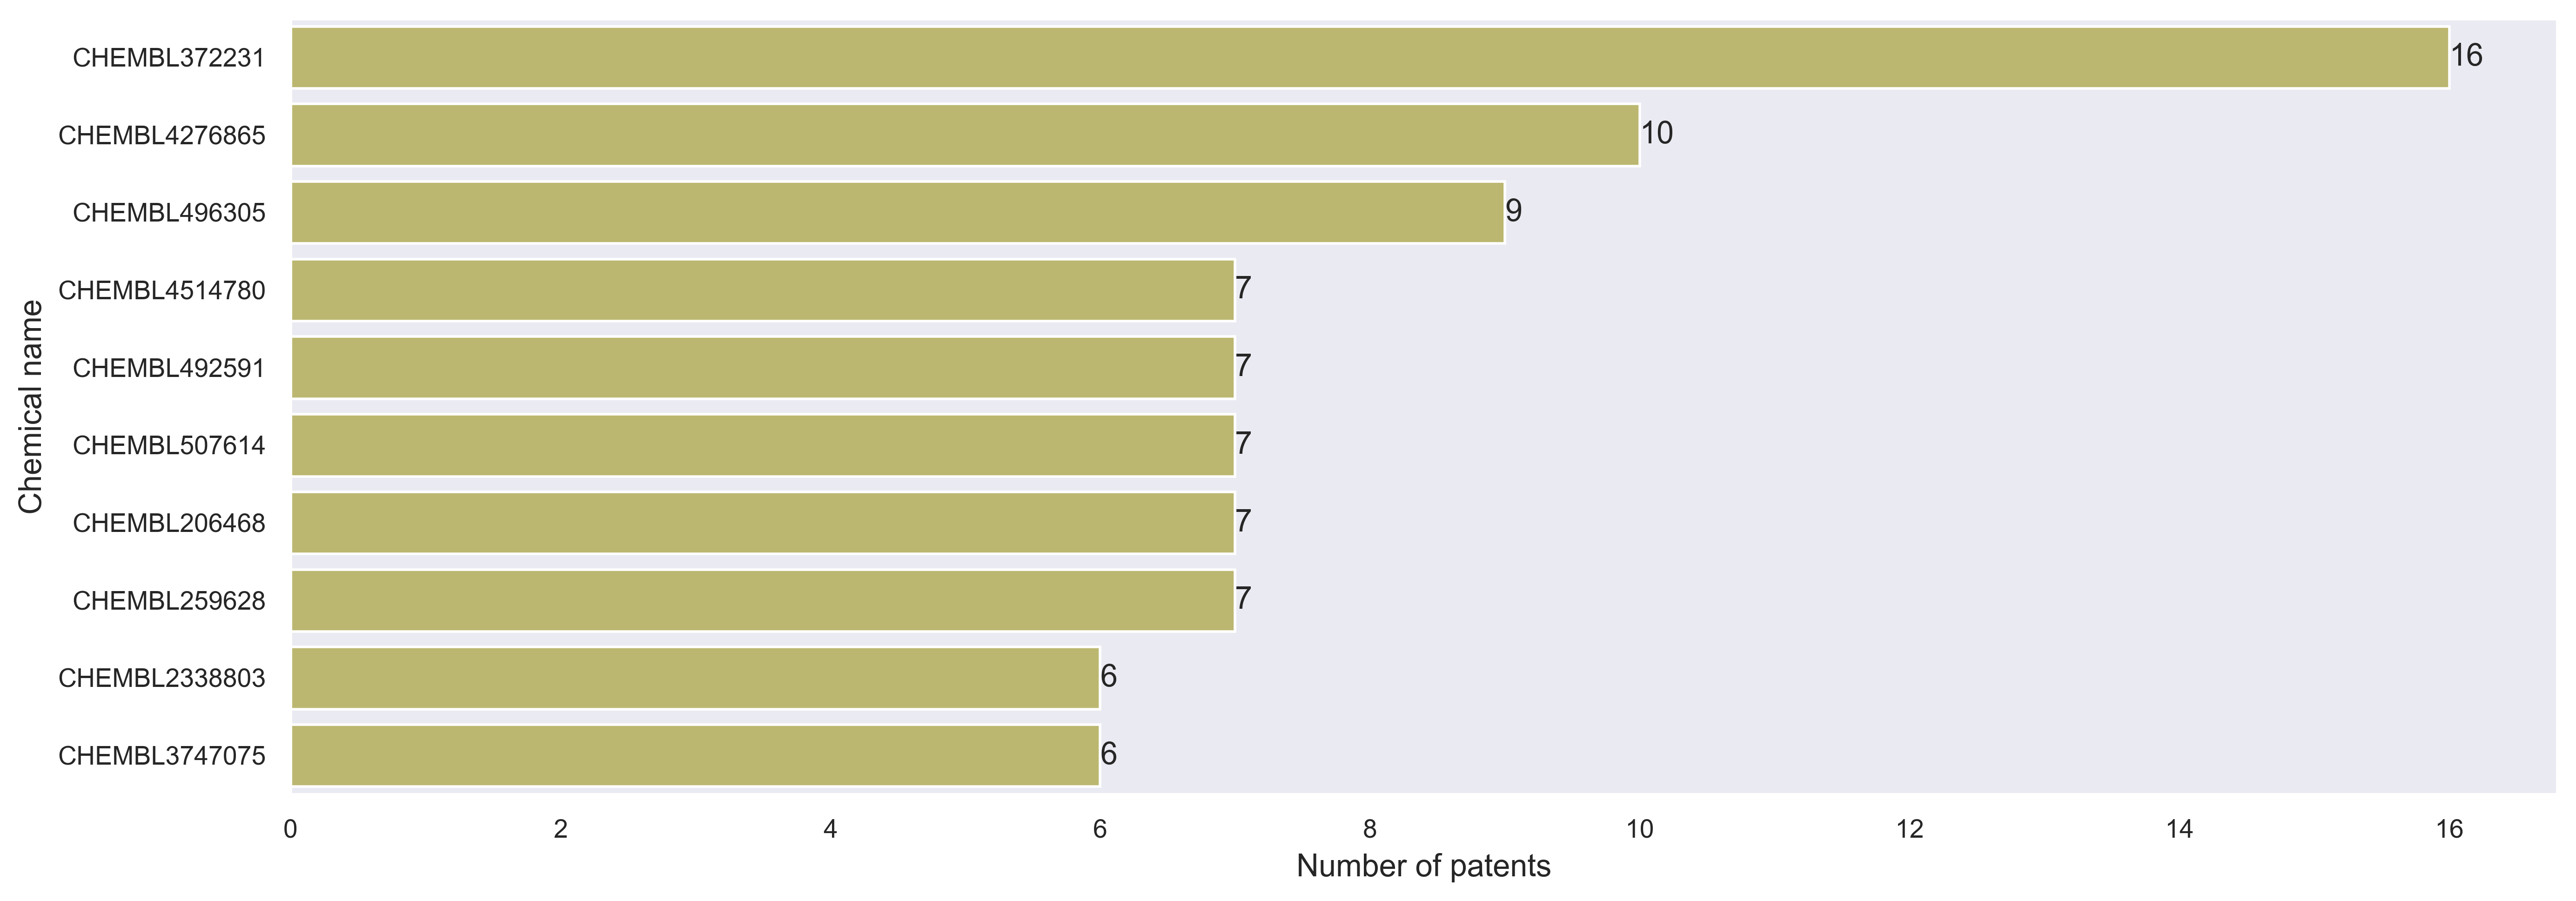

In [16]:
plt.figure(figsize=(14, 5))

ax = sns.barplot(
    data=rare_disease_compounds, 
    x='total_patent_count', y='chembl',
    color='#c7c263',
    orient='h',
)

ax.bar_label(ax.containers[0])

plt.xlabel('Number of patents', size=12)
plt.ylabel('Chemical name', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.show()

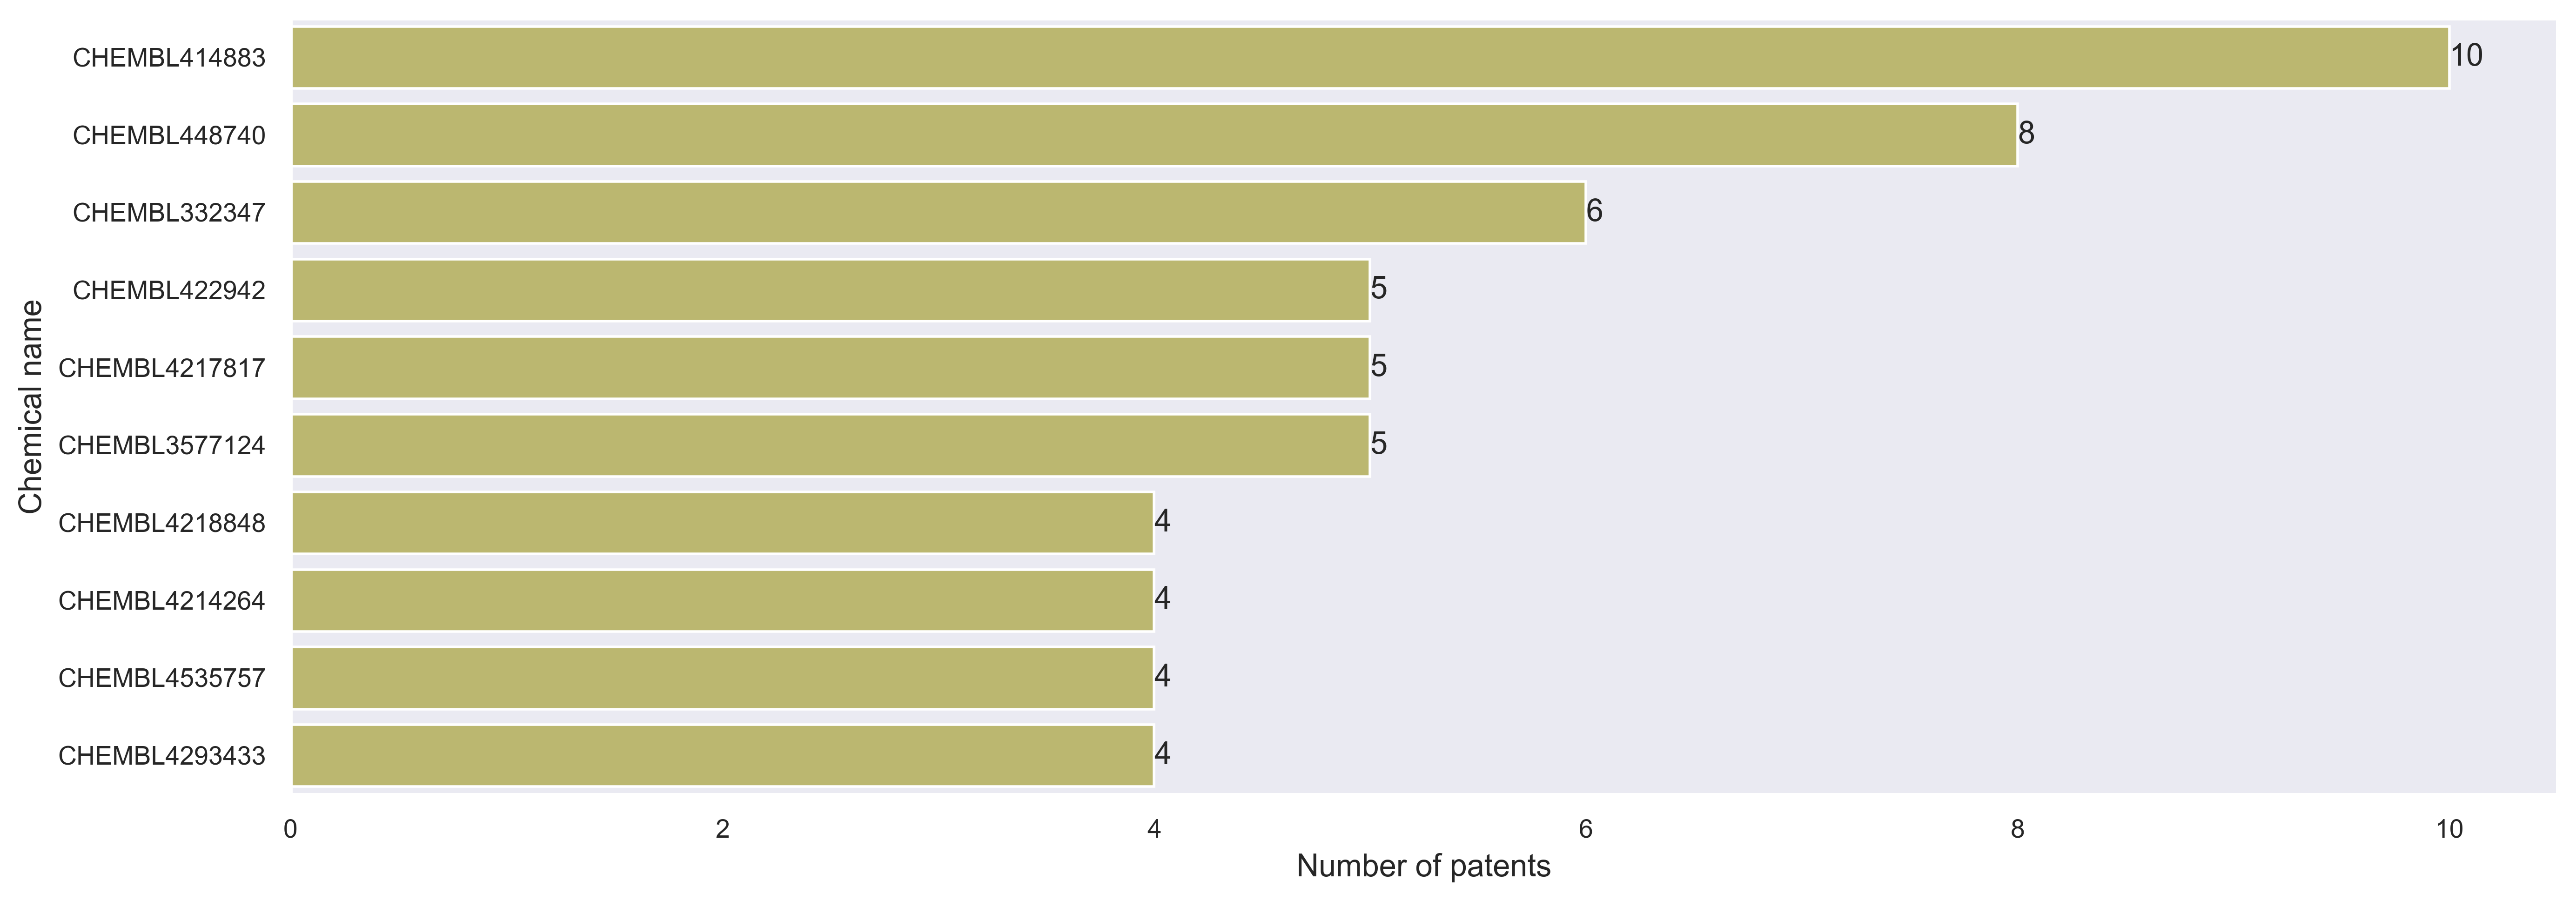

In [17]:
plt.figure(figsize=(14, 5))

ax = sns.barplot(
    data=alzheimers_disease_compounds, 
    x='total_patent_count', y='chembl',
    color='#c7c263',
    orient='h',
)

ax.bar_label(ax.containers[0])

plt.xlabel('Number of patents', size=12)
plt.ylabel('Chemical name', size=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.show()